## Sentiment analysis with amazon reviews

---
##### Table of contents

1. [Import dataset](#1-import-dataset)  
2. [EDA](#2-eda)  
3. [NLTK](#3-nltk)  
   - 3.1. [NLTK Sentiment Analyzer](#31-nltk-sentiment-analyzer)  
   - 3.2. [Plot Results NLTK](#32-plot-results-nltk)  
4. [Hugging Face RoBERTa](#4-hugging-face-roberta)  
   - 4.1. [Hugging Face RoBERTa on an Example](#41-hugging-face-roberta-on-an-example)  
   - 4.2. [Hugging Face RoBERTa on the Dataset](#42-hugging-face-roberta-on-the-dataset)  
5. [Compare NLTK VADER and Hugging Face RoBERTa Results](#5-compare-nltk-vader-and-hugging-face-roberta-results)  
   - 5.1. [Calculate the Accuracy of Each Model](#51-calculate-the-accuracy-of-each-model)  
6. [Some Examples of Misclassified Texts](#6-some-examples-of-misclassified-texts)  
   - 6.1. [1-Star Reviews](#61-1-star-reviews)  
     - 6.1.1. [NLTK VADER](#611-nltk-vader)  
     - 6.1.2. [Hugging Face RoBERTa](#612-hugging-face-roberta)  
   - 6.2. [5-Star Reviews](#62-5-star-reviews)  
     - 6.2.1. [NLTK VADER](#621-nltk-vader)  
     - 6.2.2. [Hugging Face RoBERTa](#622-hugging-face-roberta)  
7. [Hugging Face Pipeline](#7-hugging-face-pipeline)  


---

Sources dataset :
- https://www.youtube.com/watch?v=QpzMWQvxXWk
- https://www.kaggle.com/code/robikscube/sentiment-analysis-python-youtube-tutorial

Sources NLTK :
- https://github.com/nltk/nltk/wiki/Sentiment-Analysis
- https://www.nltk.org/howto/sentiment.html

Source RoBERTa :
- https://huggingface.co/docs/transformers/model_doc/roberta


</br></br>
*Not used in this notebook but another interesting model is spaCy:*

*Sources spaCy :*
- *https://www.youtube.com/watch?v=dIUTsFT2MeQ*
- *https://spacy.io/api*

*Sources spaCy TextBlob :*
- *https://spacy.io/universe/project/spacy-textblob*
- *https://www.youtube.com/watch?v=6bg-TNoT5_Y*

<a name="1"></a>
### 1. Import dataset

https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews

In [1]:
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

In [2]:
# Download latest version
path = kagglehub.dataset_download("snap/amazon-fine-food-reviews")

print("Path to dataset files:", path)

100%|██████████| 242M/242M [00:04<00:00, 62.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/snap/amazon-fine-food-reviews/versions/2


In [3]:
path = "/root/.cache/kagglehub/datasets/snap/amazon-fine-food-reviews/versions/2"
os.listdir(path)

['database.sqlite', 'hashes.txt', 'Reviews.csv']

In [4]:
data = pd.read_csv(path + "/Reviews.csv")

In [5]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
data.shape

(568454, 10)

<a name="2"></a>
### 2. EDA

In [7]:
data.isna().sum()

,0
Id,0
ProductId,0
UserId,0
ProfileName,26
HelpfulnessNumerator,0
HelpfulnessDenominator,0
Score,0
Time,0
Summary,27
Text,0


In [8]:
print(f"The amount of null data represents {data.isna().sum().sum() / data.shape[0]} % of the dataset, we can obviously remove them without any problem.")

The amount of null data represents 9.323533654438178e-05 % of the dataset, we can obviously remove them without any problem.


In [9]:
data = data.dropna()
data.isna().sum().sum()

0

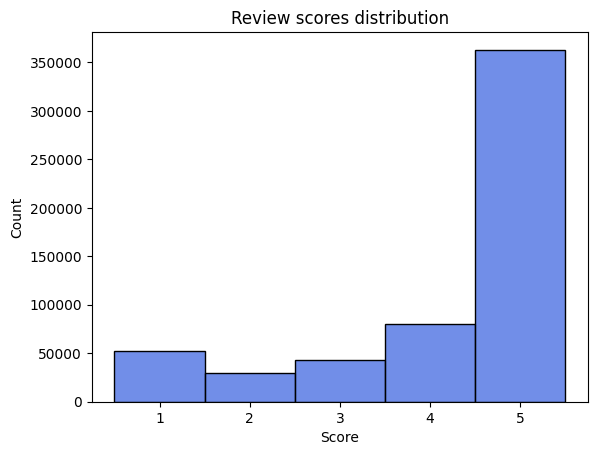

In [10]:
sns.histplot(data['Score'],
             bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5],
             color='royalblue',
             discrete=True)
plt.xticks([1, 2, 3, 4, 5])
plt.title('Review scores distribution')
plt.show()

<a name="3"></a>
### 3. NLTK

In [11]:
example = data['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [14]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [17]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [22]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


<a name="31"></a>
#### 3.1. NLTK sentiment analyzer

**Sentiment Score Calculation in NLTK VADER**  

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a **rule-based** sentiment analysis tool designed for short text, such as social media posts and reviews. It assigns sentiment scores using a **predefined lexicon** of words with intensity values.  

**1. Lexicon-Based Word Scoring**  
Each word in the lexicon has a predefined **sentiment intensity score**:  
- **Positive words** (e.g., *"great"*) have **positive scores**.  
- **Negative words** (e.g., *"terrible"*) have **negative scores**.  
- **Neutral words** (e.g., *"the"*, *"is"*) are ignored in scoring.  

**2. Adjustments Based on Context**  
- **Modifiers** (e.g., *"very"*, *"extremely"*) amplify or diminish sentiment intensity.  
- **Negations** (e.g., *"not good"*) flip the polarity of sentiment words.  
- **Punctuation & Capitalization** (e.g., *"AMAZING!!!"*) increase intensity.  

**3. Computing neg, neu, pos Scores**  
After scoring all words, VADER calculates:  
- **neg**: Proportion of words contributing to negative sentiment.  
- **neu**: Proportion of neutral words.  
- **pos**: Proportion of words contributing to positive sentiment.  

Formally, these scores are derived as:  
$$
\text{neg} = \frac{\sum (\text{negative word scores})}{\sum (\text{absolute sentiment scores})}
$$  

$$
\text{pos} = \frac{\sum (\text{positive word scores})}{\sum (\text{absolute sentiment scores})}
$$  

$$
\text{neu} = \frac{\sum (\text{neutral words})}{\text{total words}}
$$  

**4. Compound Score Calculation**  
The **compound score** is a single value representing the **overall sentiment** of the text. It is calculated as a weighted sum of sentiment scores, normalized using the **hyperbolic tangent (tanh) function**:  
$$
\text{compound} = \tanh\left(\frac{\sum (\text{word scores})}{\alpha}\right)
$$  
where **α (alpha) = 15**, ensuring values range between **-1 (most negative) to +1 (most positive)**.  


In [23]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

In [26]:
sia = SentimentIntensityAnalyzer()

In [27]:
# Example to understand what it happening
print(example)
print(sia.polarity_scores(example))

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.
{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}


We can now iterate over the dataset to get the scores.

We're just gonna crop the data to not iterate over 500000+ sentences.

In [28]:
data = data.head(500)

results = {}
for i, row in tqdm(data.iterrows(), total=len(data)):
    results[row.Id] = sia.polarity_scores(row.Text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [29]:
# Convert items to list and slice
first_5 = dict(list(results.items())[:5])

print(first_5)

{1: {'neg': 0.0, 'neu': 0.695, 'pos': 0.305, 'compound': 0.9441}, 2: {'neg': 0.138, 'neu': 0.862, 'pos': 0.0, 'compound': -0.5664}, 3: {'neg': 0.091, 'neu': 0.754, 'pos': 0.155, 'compound': 0.8265}, 4: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}, 5: {'neg': 0.0, 'neu': 0.552, 'pos': 0.448, 'compound': 0.9468}}


In [30]:
vaders = pd.DataFrame(results).T
vaders

,neg,neu,pos,compound
1,0.000,0.695,0.305,0.9441
2,0.138,0.862,0.000,-0.5664
3,0.091,0.754,0.155,0.8265
4,0.000,1.000,0.000,0.0000
5,0.000,0.552,0.448,0.9468
...,...,...,...,...
496,0.000,0.554,0.446,0.9725
497,0.059,0.799,0.142,0.7833
498,0.025,0.762,0.212,0.9848
499,0.041,0.904,0.055,0.1280


-------

Not a useful part

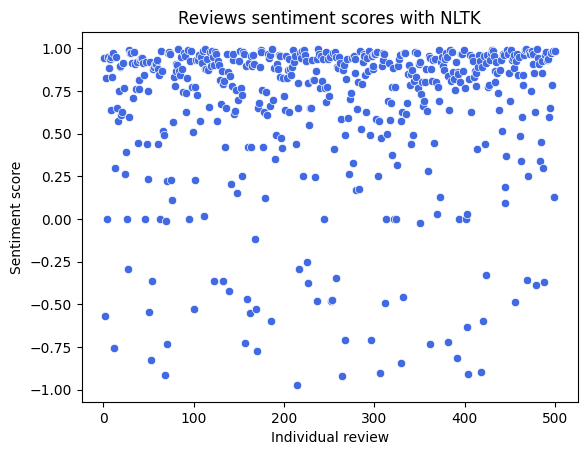

In [31]:
ax = sns.scatterplot(data=vaders, x=vaders.index, y='compound', color='royalblue')
ax.set_xlabel('Individual review')
ax.set_ylabel('Sentiment score')
plt.title('Reviews sentiment scores with NLTK')
plt.show()

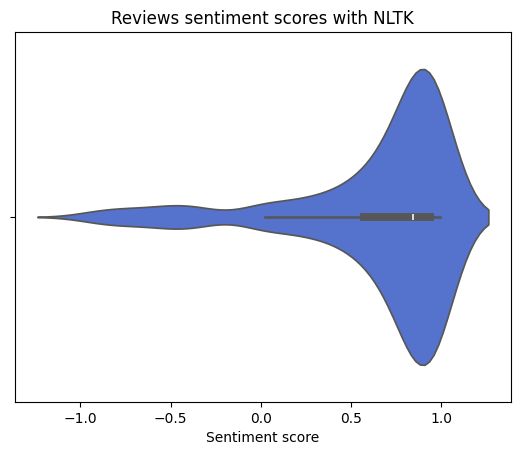

In [32]:
ax = sns.violinplot(data=vaders, x='compound', color='royalblue')
ax.set_title('Reviews sentiment scores with NLTK')
ax.set_xlabel('Sentiment score')
plt.show()

------------

In [33]:
# We merge the vaders df with the dataset to get both sentiment scores and metadata
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(data, how='left')

In [34]:
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


<a name="32"></a>
#### 3.2. Plot results NLTK

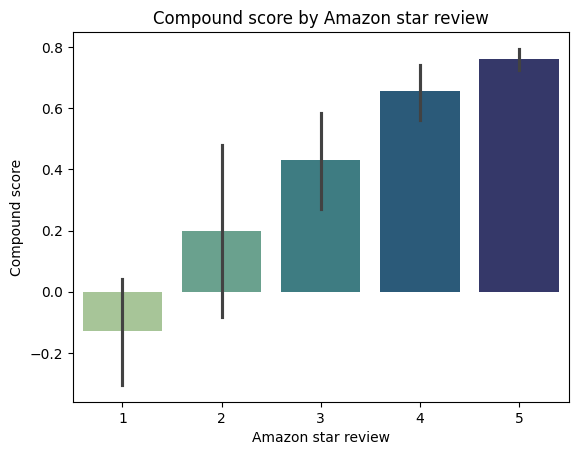

In [35]:
ax = sns.barplot(data=vaders, x='Score', y='compound', hue='Score', palette='crest', legend=False)
ax.set_title('Compound score by Amazon star review')
ax.set_xlabel('Amazon star review')
ax.set_ylabel('Compound score')
plt.show()

- As we could expect, there is a **strong correlation between star rating and sentiment score**:  
  - **Higher-rated reviews** (4-5 stars) tend to be strongly positive.  
  - **Lower-rated reviews** (1-2 stars) tend to be negative or neutral.  
- The variability in sentiment suggests that **some reviews do not always match their star rating exactly** (e.g., a 1-star review may still have neutral wording).

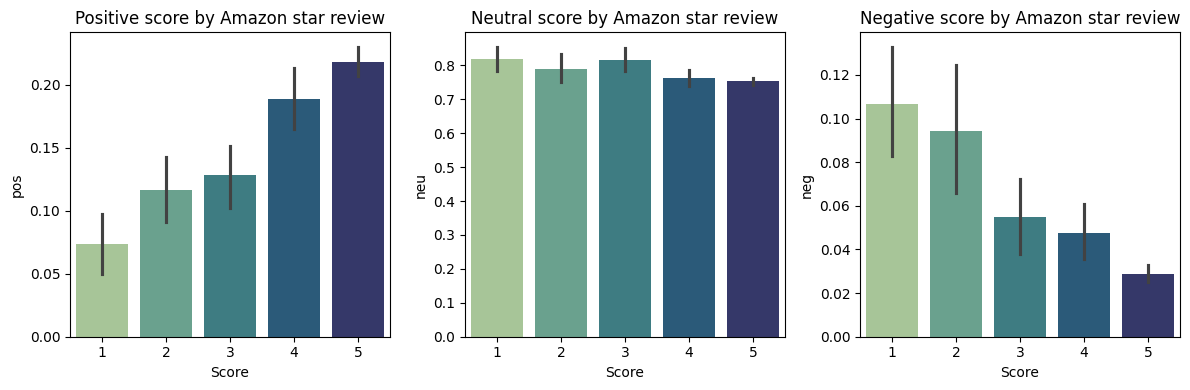

In [36]:
# Create 3 subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot Positive Scores
sns.barplot(data=vaders, x='Score', y='pos', hue='Score', palette='crest', legend=False, ax=axes[0])
axes[0].set_title('Positive score by Amazon star review')

# Plot Neutral Scores
sns.barplot(data=vaders, x='Score', y='neu', hue='Score', palette='crest', legend=False, ax=axes[1])
axes[1].set_title('Neutral score by Amazon star review')

# Plot Negative Scores
sns.barplot(data=vaders, x='Score', y='neg', hue='Score', palette='crest', legend=False, ax=axes[2])
axes[2].set_title('Negative score by Amazon star review')

# Improve layout
plt.tight_layout()
plt.show()

- Once again, as we could expect, there is a strong correlation between star rating and each sentiment score:
  - **Higher star ratings** correspond to stronger positive sentiment, while lower star ratings contain more negativity.
  - **Neutral sentiment** is fairly consistent across all ratings, meaning some reviews contain balanced wording.
  - VADER sentiment analysis effectively captures sentiment variations in Amazon reviews, aligning well with human expectations.

---
<br>

**NLTK vs. RoBERTa for Sentiment Analysis**  

NLTK and RoBERTa are both used for **sentiment analysis**, but they differ in **methodology, accuracy, and complexity**. Below is a comparison of the two approaches. <br><br>



**Overview of NLTK and RoBERTa**

| Feature        | **NLTK (VADER Sentiment Analyzer)** | **RoBERTa (Transformer Model)** |
|--------------|--------------------------------|--------------------------------|
| **Model Type** | Rule-based lexicon model | Deep learning transformer model |
| **Approach** | Uses a pre-defined sentiment lexicon and heuristics | Uses pre-trained deep learning embeddings from large-scale data |
| **Training Data** | No training required; based on a **fixed lexicon** | Pre-trained on **160GB+ of text data** |
| **Sentiment Scores** | Outputs **negative, neutral, positive**, and **compound** scores | Outputs **probability scores for each sentiment category** |
| **Context Awareness** | **Limited**; does not understand complex sentence structures, sarcasm, or negation well | **High**; understands deep semantic relationships, context, and sarcasm |
| **Computational Cost** | **Low**; runs fast on CPU | **High**; requires GPU for efficient performance |
| **Best For** | Quick sentiment analysis on short texts like social media, product reviews, etc. | Advanced sentiment analysis for long-form text, including news articles, tweets, and customer feedback |

<br><br>

**Key Differences**

- **Lexicon-based vs. Deep Learning**

  - **NLTK (VADER)** relies on a **fixed set of words with predefined sentiment scores**.
  - **RoBERTa** is a **contextual model** that learns from **massive text datasets** and understands words in relation to surrounding words.

<br>

---

<a name="4"></a>
### 4. RoBERTa

---

</br>


**RoBERTa Pretrained Model for Sentiment Analysis**  

RoBERTa (Robustly Optimized BERT Pretraining Approach) is a transformer-based model developed by **Facebook AI**. It is an improved version of **BERT (Bidirectional Encoder Representations from Transformers)**, trained with more **data, larger batch sizes, and dynamic masking**, making it more powerful for **natural language understanding (NLU) tasks**, including **sentiment analysis**.

---

**How RoBERTa works for Sentiment Analysis**

RoBERTa follows a **three-step process** to analyze sentiment from text:

- **Step 1: Tokenization and Input Processing**
  - The text is first **tokenized** using the **Byte-Pair Encoding (BPE)** tokenizer.
  - Special tokens such as:
    - **`[CLS]`** (classification token) are added at the beginning.
    - **`[SEP]`** (separator token) is used if needed.
  - The model converts words into **word embeddings**, numerical representations that capture meaning.

- **Step 2: Transformer Encoding**
  - The tokenized input passes through **multiple self-attention layers** in the **Transformer architecture**.
  - The model **contextually understands** the sentence using a **bidirectional approach**, meaning it takes into account words **before and after** a given word.
  - RoBERTa is pre-trained on **large-scale datasets** using the **masked language model (MLM) objective**, improving its ability to understand sentiment.

- **Step 3: Sentiment Classification**
  - The final hidden state of the **`[CLS]` token** is passed to a **fully connected classification layer**.
  - The model outputs **probabilities for each sentiment class**:
    - **Positive**  
    - **Neutral**  
    - **Negative**  
  - The sentiment with the highest probability is chosen as the final **prediction**.

---

**Key Features that make RoBERTa powerful**

- **Dynamic Masking**: Unlike BERT, RoBERTa uses a more efficient **dynamic masking** technique to train better representations.  
- **Trained on More Data**: RoBERTa is trained on **160GB of text data**, including **books, Wikipedia, and web text**, making it more robust.  
- **No Next Sentence Prediction (NSP)**: Unlike BERT, RoBERTa **removes the NSP task**, focusing purely on token-level language modeling, leading to better context understanding.  

---

**Why use RoBERTa for Sentiment Analysis?**
- **Better performance than BERT** in text classification tasks.  
- **Understands context more effectively**, reducing errors from sarcasm, negation, or complex sentences.  
- **Works well on small and large datasets**, making it ideal for **social media sentiment analysis, product reviews, and customer feedback.**  

---

**Using RoBERTa for Sentiment Analysis**

To use RoBERTa for sentiment analysis, we can leverage the **Hugging Face Transformers library** *(watch the 7. part of the notebook)*:

```python
from transformers import pipeline

# Load RoBERTa sentiment analysis model
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")

# Example text
text = "I love this product! It's absolutely amazing."

# Get prediction
result = sentiment_pipeline(text)
print(result)
```

</br>

---

In [37]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [38]:
# Import an already trained model to use it for our amazon reviews
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

<a name="41"></a>
#### 4.1. RoBERTa on our example

In [39]:
# Sentiment score on our example above with NLTK
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [40]:
# Sentiment score on our example above with Hugging Face RoBERTa
print(example)

# Convert text into tokenized input for the model ensuring the output is in PyTorch tensor format with return_tensors='pt'
# This part is necessary because we convert the input text into a format the RoBERTa model can understand
model_input_example = tokenizer(example, return_tensors='pt')

# Pass the tokenized text into the RoBERTa model
# The model processes the input and generates logits (raw output scores before applying softmax) for each sentiment class (e.g., negative, neutral, positive)
model_output = model(**model_input_example)

model_output

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

SequenceClassifierOutput(loss=None, logits=tensor([[ 3.1436, -0.7107, -2.6559]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [41]:
type(model_output)

transformers.modeling_outputs.SequenceClassifierOutput

In [42]:
scores = model_output[0][0].detach().numpy()     # the result is : "[negative, neutral, positive]"
scores

array([ 3.1436296, -0.7106689, -2.6558962], dtype=float32)

In the code above `model_output[0][0].detach().numpy()`:
- `model_output[0]`: Accesses the first output of the model (logits for sentiment classes).
- `[0]`: Extracts the first set of logits (for the first sentence in the batch).
.detach():
  - Removes the tensor from the PyTorch computation graph (this is necessary to prevent unnecessary gradient tracking).
- `.numpy()`: Converts the PyTorch tensor into a NumPy array, making it easier to manipulate or analyze.

In [43]:
# Then we apply the softmax to our scores
print(example)
scores = softmax(scores)
scores

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


array([0.97635514, 0.02068746, 0.00295737], dtype=float32)

**The RoBERTa models predicts that the example we took is 97% negative where the NLTK model predicts this is 22% negative and 78% neutral.**

---

</br>

You pass the score from RoBERTa through softmax because the raw logits are not probabilities, and the softmax converts these logits into probabilities that can be interpreted as confidence in each class. This is essential for tasks like classification, where you need a clear probabilistic understanding of the model’s predictions.

</br>

*Cheat sheet :*

$$
\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{n} e^{z_j}}
$$

*The output is a vector of probabilities \( p = [p_1, p_2, ..., p_n] \) such that:*

$$
p_i = \frac{e^{z_i}}{\sum_{j=1}^{n} e^{z_j}}, \quad \text{and} \quad \sum_{i=1}^{n} p_i = 1
$$

</br>

---

<a name="42"></a>
#### 4.2. RoBERTa on the 500 observations

In [44]:
def polarity_scores_roberta(example):
    model_input = tokenizer(example, return_tensors='pt')
    model_output = model(**model_input)
    scores = model_output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [45]:
# Iterate over our 500 observations
results = {}
for i, row in tqdm(data.iterrows(), total=len(data)):
    try:
        ## Run Vader over our 500
        vader_result = sia.polarity_scores(row.Text)

        ## Rename neg, neu, pos, compound for vader_neg, vader_neu...
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value

        ## Run RoBERTa model over our 500
        roberta_result = polarity_scores_roberta(row.Text)

        ## Combine both dict into one
        both = {**vader_result_rename, **roberta_result}
        results[row.Id] = both

    except RuntimeError:
        print(f'Broke for id {row.Id}')

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


In [46]:
results_df = pd.DataFrame(results).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(data, how='left')

In [47]:
results_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


<a name="5"></a>
### 5. Compare VADER and RoBERTa results

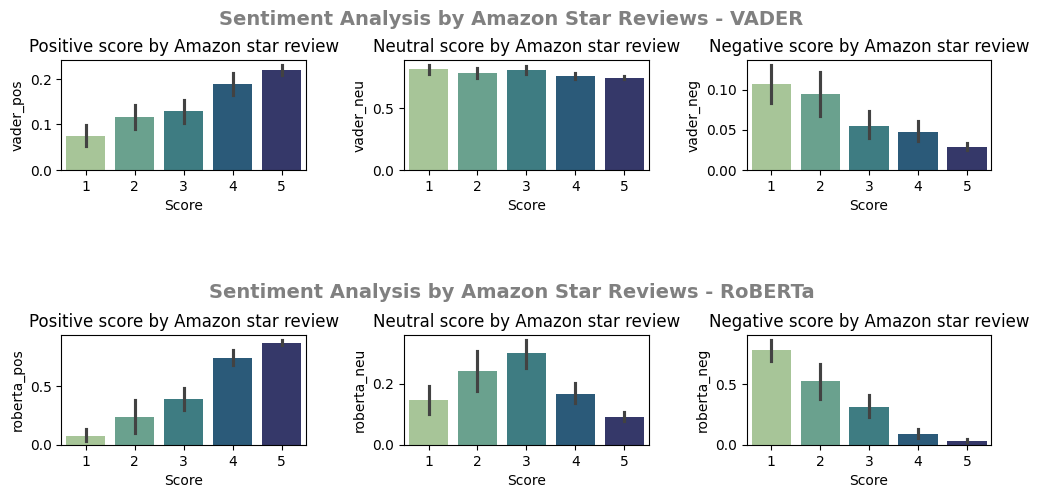

In [48]:
# Create 3 subplots (1 row, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(12, 5))

"""""""""""""""
Vader plots
"""""""""""""""
# Plot Positive Scores
sns.barplot(data=results_df, x='Score', y='vader_pos', hue='Score', palette='crest', legend=False, ax=axes[0, 0])
axes[0, 0].set_title('Positive score by Amazon star review')

# Plot Neutral Scores
sns.barplot(data=results_df, x='Score', y='vader_neu', hue='Score', palette='crest', legend=False, ax=axes[0, 1])
axes[0, 1].set_title('Neutral score by Amazon star review')

# Plot Negative Scores
sns.barplot(data=results_df, x='Score', y='vader_neg', hue='Score', palette='crest', legend=False, ax=axes[0, 2])
axes[0, 2].set_title('Negative score by Amazon star review')


"""""""""""""""
RoBERTa plots
"""""""""""""""
# Plot Positive Scores
sns.barplot(data=results_df, x='Score', y='roberta_pos', hue='Score', palette='crest', legend=False, ax=axes[1, 0])
axes[1, 0].set_title('Positive score by Amazon star review')

# Plot Neutral Scores
sns.barplot(data=results_df, x='Score', y='roberta_neu', hue='Score', palette='crest', legend=False, ax=axes[1, 1])
axes[1, 1].set_title('Neutral score by Amazon star review')

# Plot Negative Scores
sns.barplot(data=results_df, x='Score', y='roberta_neg', hue='Score', palette='crest', legend=False, ax=axes[1, 2])
axes[1, 2].set_title('Negative score by Amazon star review')


# Subplot rows Titles
fig.text(0.5, 0.95, 'Sentiment Analysis by Amazon Star Reviews - VADER', ha='center', fontsize=14, fontweight='bold', color='grey')
fig.text(0.5, 0.405, 'Sentiment Analysis by Amazon Star Reviews - RoBERTa', ha='center', fontsize=14, fontweight='bold', color='grey')

# Improve layout
plt.subplots_adjust(hspace=1.5, wspace=0.4)  # Adjust vertical space
#plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

- **VADER** tends to assign **higher neutral** scores and **weaker positive/negative scores**, making it **less precise** in detecting strong emotions.
- **RoBERTa** captures sentiment **more sharply** and **differentiates better** between ratings, making it the **more effective model** for sentiment analysis.

<a name="51"></a>
### 5.1. Calculate the accuracy of each models

**This section is simply a comparison between the two models. For the accuracy calculation to be correct, the consumers who rate should write a review that is objectively considered as 1, 2, 3, 4, or 5 stars. Of course, it’s possible that a consumer may not be entirely negative in their review despite giving 1 star, or they may be completely negative in their review even though they gave 3 stars. It all depends on how they interpret the rating.**

**That being said, the two models are compared using the same dataset, so it’s possible to determine whether one model is better than the other at detecting emotions in text.**

In [49]:
# Use the same method as for vader_compound to calculate roberta_compound

def calculate_roberta_compound(row):
    # Check to avoid division by zero
    total_score = row['roberta_pos'] + row['roberta_neg'] + row['roberta_neu']

    if total_score == 0:
        return 0  # If the sum is zero, return 0 (neutral)

    # Calculate the compound score using the same principles as VADER
    compound_score = (row['roberta_pos'] - row['roberta_neg']) / total_score
    return compound_score

def assign_stars_from_compound(compound_score):
    # Convert the compound score to stars (1 to 5)
    if compound_score <= -0.6:
        return 1
    elif compound_score <= -0.2:
        return 2
    elif compound_score <= 0.2:
        return 3
    elif compound_score <= 0.6:
        return 4
    else:
        return 5

# Create a new DataFrame to avoid modifying the original one
results_df2 = results_df.copy()

# Apply the compound score calculation to the new DataFrame
results_df2['roberta_compound'] = results_df2.apply(calculate_roberta_compound, axis=1)

# Convert the RoBERTa compound score to stars
results_df2['roberta_stars'] = results_df2['roberta_compound'].apply(assign_stars_from_compound)

# Convert the VADER compound score to stars
results_df2['vader_stars'] = results_df2['vader_compound'].apply(assign_stars_from_compound)

# Optional: Display the new DataFrame with the results
results_df2.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,roberta_compound,roberta_stars,vader_stars
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,0.930771,5,5
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,-0.470386,2,2
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,0.895475,5,5
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0.905191,5,3
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,0.986428,5,5


In [50]:
# Comparaison entre Vader et les étoiles données par les consommateurs
results_df2['vader_diff'] = abs(results_df2['vader_stars'] - results_df2['Score'])
results_df2['vader_correct'] = results_df2['vader_stars'] == results_df2['Score']

# Comparaison entre RoBERTa et les étoiles données par les consommateurs
results_df2['roberta_diff'] = abs(results_df2['roberta_stars'] - results_df2['Score'])
results_df2['roberta_correct'] = results_df2['roberta_stars'] == results_df2['Score']

# Optionnel : Calculer la précision de chaque modèle (pourcentage de prédictions correctes)
vader_accuracy = results_df2['vader_correct'].mean() * 100  # Pourcentage de prédictions correctes de VADER
roberta_accuracy = results_df2['roberta_correct'].mean() * 100  # Pourcentage de prédictions correctes de RoBERTa

# Affichage des résultats
print("Vader Accuracy: {:.2f}%".format(vader_accuracy))
print("RoBerta Accuracy: {:.2f}%".format(roberta_accuracy))

Vader Accuracy: 61.45%
RoBerta Accuracy: 68.47%


**It's difficult to definitively say that the RoBERTa model is better than the NLTK VADER model based solely on these accuracy results.**

**As mentioned earlier, RoBERTa is more sophisticated, and the dataset's distribution is left-skewed, with a high number of 5-star reviews. This type of distribution could make it easier for the RoBERTa model to perform better, as it is capable of capturing more nuanced sentiment patterns.**

**However, accuracy alone is just a quick way to compare the two models and doesn't provide a complete picture of their performance.**

<a name="6"></a>
### 6. Some examples of miss classified texts from RoBERTa and NLTK VADER

<a name="61"></a>
#### 6.1. 1-Star reviews

<a name="611"></a>
##### 6.1.1. NLTK VADER

In [51]:
# Extract results where Score == 1, sorted by 'vader_pos' in descending order
top_vader_pos = results_df.query('Score == 1').sort_values('vader_pos', ascending=False)

# Get the top 3 values for 'vader_pos' and their corresponding 'Text'
vader_pos_values = top_vader_pos['vader_pos'].values[0:3]
texts = top_vader_pos['Text'].values[0:3]

# Format the output
formatted_results = [f"Text: \"{text}\", vader_pos value = {pos}" for text, pos in zip(texts, vader_pos_values)]

# Print each result
for result in formatted_results:
    print(result)

Text: "So we cancelled the order.  It was cancelled without any problem.  That is a positive note...", vader_pos value = 0.274
Text: "Seriously this product was as tasteless as they come. There are much better tasting products out there but at 100 calories its better than a special k bar or cookie snack pack. You just have to season it or combine it with something else to share the flavor.", vader_pos value = 0.223
Text: "I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.", vader_pos value = 0.172


<a name="612"></a>
##### 6.1.2. RoBERTa

In [52]:
# Extract results where Score == 1, sorted by 'roberta_pos' in descending order
top_roberta_pos = results_df.query('Score == 1').sort_values('roberta_pos', ascending=False)

# Get the top 3 values for 'roberta_pos' and their corresponding 'Text'
roberta_pos_values = top_roberta_pos['roberta_pos'].values[0:3]
texts = top_roberta_pos['Text'].values[0:3]

# Format the output
formatted_results = [f"Text: \"{text}\", roberta_pos value = {pos}" for text, pos in zip(texts, roberta_pos_values)]

# Print each result
for result in formatted_results:
    print(result)

Text: "I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.", roberta_pos value = 0.6256366968154907
Text: "To me, these are nothing like the regular Altoids and are not breath mints. They are pleasant-tasting little candies in a cute convenient tin, and that's as far as it goes. The mintiness is just not strong, and the wintergreens are definitely weaker than the peppermint minis. I'm not a dragon-breath person, but still, one of these mints is too small to have any effect on my breath. Four or five will freshen my breath for a short while - maybe 15 minutes. At this point, I think the Icebreakers Frost mints are the best as sugar free breath mints.", roberta_pos value = 0.6218560338020325
Text: "So we cancelled the order.  It was cancelled without any problem.  That is a positive note...", roberta_pos value = 0.6071791648864746


<a name="62"></a>
#### 6.2. 5-Stars reviews

<a name="621"></a>
##### 6.2.1. NLTK VADER

In [53]:
# Extract results where Score == 5, sorted by 'vader_neg' in descending order
top_vader_neg = results_df.query('Score == 5').sort_values('vader_neg', ascending=False)

# Get the top 3 values for 'vader_neg' and their corresponding 'Text'
vader_neg_values = top_vader_neg['vader_neg'].values[0:3]
texts = top_vader_neg['Text'].values[0:3]

# Format the output
formatted_results = [f"Text: \"{text}\", vader_neg value = {neg}" for text, neg in zip(texts, vader_neg_values)]

# Print each result
for result in formatted_results:
    print(result)

Text: "this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault", vader_neg value = 0.344
Text: "What a deal this is the healthiest salt you can use.  This box should last our family the year no problem.  Iodized sea salt will not raise your blood pressure as regular salt will.", vader_neg value = 0.191
Text: "We had trouble finding this locally - delivery was fast, no more hunting up and down the flour aisle at our local grocery stores.", vader_neg value = 0.189


<a name="622"></a>
##### 6.2.2. RoBERTa

In [54]:
# Extract results where Score == 5, sorted by 'roberta_neg' in descending order
top_roberta_neg = results_df.query('Score == 5').sort_values('roberta_neg', ascending=False)

# Get the top 3 values for 'roberta_neg' and their corresponding 'Text'
roberta_neg_values = top_roberta_neg['roberta_neg'].values[0:3]
texts = top_roberta_neg['Text'].values[0:3]

# Format the output
formatted_results = [f"Text: \"{text}\", roberta_neg value = {neg}" for text, neg in zip(texts, roberta_neg_values)]

# Print each result
for result in formatted_results:
    print(result)

Text: "this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault", roberta_neg value = 0.9601579308509827
Text: "i know i cannot make tea this good.  granted, i am not from the south but i know i have never enjoyed tea that was this sweet without being too sweet.  it tastes crisp.", roberta_neg value = 0.6261535286903381
Text: "I have lived out of the US for over 7 yrs now, and I so miss my Twizzlers!!  When I go back to visit or someone visits me, I always stock up.  All I can say is YUM!<br />Sell these in Mexico and you will have a faithful buyer, more often than I'm able to buy them right now.", roberta_neg value = 0.44952747225761414


Since the RoBERTa model is more sensitive, it can sometimes interpret a positive comment with jokes as negative (as shown by the example: "*this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault*" which has a `roberta_neg` score of 0.96).

<a name="7"></a>
### 7. RoBERTa Hugging Face pipeline

In [55]:
from transformers import pipeline

sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")

Device set to use cpu


In [56]:
sentiment_pipeline("I love brownie !")

[{'label': 'LABEL_2', 'score': 0.986213743686676}]

In [57]:
sentiment_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


In [58]:
sentiment_pipeline("I love brownie !")

[{'label': 'POSITIVE', 'score': 0.9998780488967896}]